# DTSA 5511 Monet Painting Kaggle Mini Project

## ## Project Topic

This project is about building a Generative Adversarial Network (GAN) model that generates images in the style of Monet.

Our approach for this project is to understand, build, train and evaluate two different CycleGAN designs and compare their performance.

* A CycleGAN with pre-built Pix2Pix-based Generator-Discriminator from Tensorflow Tutorial
* A CycleGAN from Kaggle Tutorial

In [14]:
# libraries requiring installation
try:
  import tensorflow_addons as tfa
  from tensorflow_examples.models.pix2pix import pix2pix

except:
  !pip install -U tensorflow-addons
  !pip install git+https://github.com/tensorflow/examples.git
#  os.kill(os.getpid(), 9)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
##### added line to ensure plots are showing
%matplotlib inline
#####

# Libraries for downloading files
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
from IPython.display import clear_output
import tarfile
import shutil
import time

# Common Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#import kaggledatasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

Device: 
Number of replicas: 8
2.15.0


In [3]:
# Mounting google drive to store the best models
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download Data Files from Kaggle

In [4]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'monet-gan-getting-started:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F21755%2F1475600%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240624%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240624T115311Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D276dc8b1bc14de1b325c801d2b4d848d516f52c7689f91d15640688d27814205c5b01e8a466395afa865dcc1a75f41b203fbf235fe1a2032011e6be371cfe57bf1e6649bec1c694ac925084f754bd9bc242616ff7e2e9913212a5299522854244cab73d09fdf9f3ca0a416b5c838ccd41d18a16ae9c5eaab2a476fa433cb91b79ee4776ff72a1361232e6a618b84edf96a75e1f36d858c5538badcdc20afc9755b5dfb332137ad1ddf00b13d93117e38bcb404e64323a564755c5393eb42fa1be35d102eef40b649f47706335bd048528d2db1a3af567df5c89bd1326970c35e23e00fc05c2102692250e3c1db02b99659488b665b68daeb973de4d30cec2d26'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 384799057 bytes downloaded
Downloaded and uncompressed: monet-gan-getting-started
Data source import complete.


## The Dataset

The Dataset is a collection of Monet painting and regular photos.

Files:
* monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
* monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
* photo_jpg - 7028 photos sized 256x256 in JPEG format
* photo_tfrec - 7028 photos sized 256x256 in TFRecord format

Source: https://www.kaggle.com/competitions/gan-getting-started/data  


## Exploratory Data Analysis

### Exploring the Project Folders

Display what is inside of the newly created project folder.

In [5]:
# Display content of the project folder
proj_path = '/kaggle/input/monet-gan-getting-started'

# Display project main path sub-folders
proj_subfolders = next(os.walk(proj_path))[1]
print('Project sub-folders:', proj_subfolders)

# Display project main path files
proj_root_files = next(os.walk(proj_path))[2]
print('Project root files:', proj_root_files)

Project sub-folders: ['monet_tfrec', 'monet_jpg', 'photo_tfrec', 'photo_jpg']
Project root files: []


### Loading the Datasets

Get paintings and photos filenames from the project's folders.

In [6]:
MONET_FILENAMES = tf.io.gfile.glob(str(proj_path + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(proj_path + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [7]:
# print monet filenames list
MONET_FILENAMES[:5]

['/kaggle/input/monet-gan-getting-started/monet_tfrec/monet12-60.tfrec',
 '/kaggle/input/monet-gan-getting-started/monet_tfrec/monet08-60.tfrec',
 '/kaggle/input/monet-gan-getting-started/monet_tfrec/monet16-60.tfrec',
 '/kaggle/input/monet-gan-getting-started/monet_tfrec/monet00-60.tfrec',
 '/kaggle/input/monet-gan-getting-started/monet_tfrec/monet04-60.tfrec']

In [8]:
# print photo filenames list
PHOTO_FILENAMES[:5]

['/kaggle/input/monet-gan-getting-started/photo_tfrec/photo02-352.tfrec',
 '/kaggle/input/monet-gan-getting-started/photo_tfrec/photo10-352.tfrec',
 '/kaggle/input/monet-gan-getting-started/photo_tfrec/photo05-352.tfrec',
 '/kaggle/input/monet-gan-getting-started/photo_tfrec/photo15-352.tfrec',
 '/kaggle/input/monet-gan-getting-started/photo_tfrec/photo07-352.tfrec']

Define Functions for Handling TFRecord Files

In [9]:
# setting functions to decode images, read tfrecords, and extract the image from the files
IMAGE_SIZE = [256, 256]

# decode images function
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

# read tfrecord
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

# extract the image from the files
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Load the dataset from the TFRecord files.

In [10]:
# create datasets from TFRecord files
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

### Images Vizualization

Extract an example image from each dataset and visualize them.

In [11]:
# extract one example image from each dataset
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

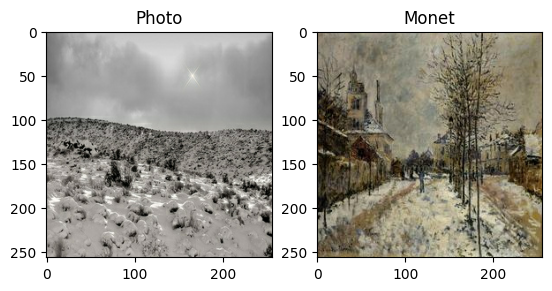

In [12]:
# Visualize the images
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

## Build and Train a Pre-built CycleGAN with Pix2Pix (Tensorflow Tutorial)

### Build the Generator & Discriminator

Import the generator and the discriminator used in Pix2Pix via the installed tensorflow_examples package.

In [15]:
OUTPUT_CHANNELS = 3

generator_m = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_p = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_m = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_p = pix2pix.discriminator(norm_type='instancenorm', target=False)

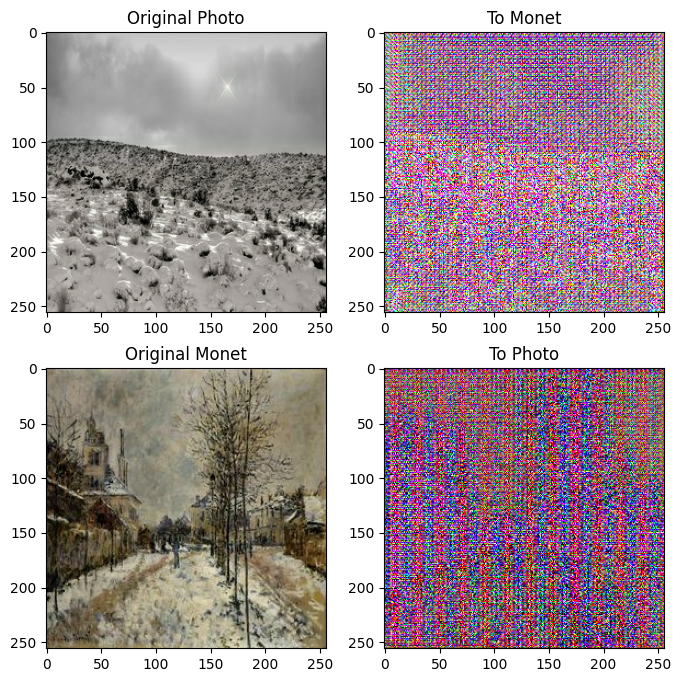

In [16]:
# display untrained generators outputs
to_monet = generator_m(example_photo, training=False)
to_photo = generator_p(example_monet, training=False)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [example_photo, to_monet, example_monet, to_photo]
title = ['Original Photo', 'To Monet', 'Original Monet', 'To Photo']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

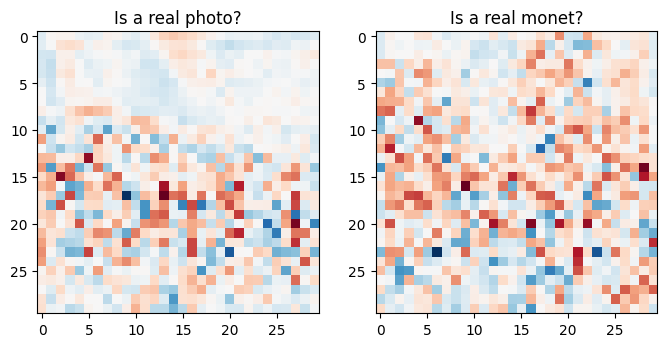

In [17]:
# display untrained discriminators outputs
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real photo?')
plt.imshow(discriminator_p(example_photo)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real monet?')
plt.imshow(discriminator_m(example_monet)[0, ..., -1], cmap='RdBu_r')

plt.show()

### Loss Functions and Optimizers for Both Model

Define loss functions and optimizers for both models.

In [18]:
LAMBDA = 10

# loss method
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#### Discriminator Loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [19]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

#### Generator Loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [20]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

### Consistancy & Identity Losses

Define functions for calculating the cycle loss and the identify loss.

In [21]:
# cycle X -> G -> Y -> D -> X loss
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [22]:
# Y -> G -> Y*
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

### Optimizers

Initialize the optimizers for all the generators and the discriminators.

In [25]:
generator_m_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_p_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_m_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_p_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### Save Checkpoints

Set checkpoints to save the model during training.

In [26]:
checkpoint_path = '/content/drive/MyDrive/training_checkpoints'
ckpt = tf.train.Checkpoint(generator_g=generator_m,
                           generator_f=generator_p,
                           discriminator_x=discriminator_m,
                           discriminator_y=discriminator_p,
                           generator_g_optimizer=generator_m_optimizer,
                           generator_f_optimizer=generator_p_optimizer,
                           discriminator_x_optimizer=discriminator_m_optimizer,
                           discriminator_y_optimizer=discriminator_p_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

### Build the CycleGAN

Set the training loop consisting of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [27]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_m(real_x, training=True)
    cycled_x = generator_p(fake_y, training=True)

    fake_x = generator_p(real_y, training=True)
    cycled_y = generator_m(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_p(real_x, training=True)
    same_y = generator_m(real_y, training=True)

    disc_real_x = discriminator_m(real_x, training=True)
    disc_real_y = discriminator_p(real_y, training=True)

    disc_fake_x = discriminator_m(fake_x, training=True)
    disc_fake_y = discriminator_p(fake_y, training=True)

    # calculate the loss
    gen_m_loss = generator_loss(disc_fake_y)
    gen_p_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_m_loss = gen_m_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_p_loss = gen_p_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_m_gradients = tape.gradient(total_gen_m_loss,
                                        generator_m.trainable_variables)
  generator_p_gradients = tape.gradient(total_gen_p_loss,
                                        generator_p.trainable_variables)

  discriminator_m_gradients = tape.gradient(disc_x_loss,
                                            discriminator_m.trainable_variables)
  discriminator_p_gradients = tape.gradient(disc_y_loss,
                                            discriminator_p.trainable_variables)

  # Apply the gradients to the optimizer
  generator_m_optimizer.apply_gradients(zip(generator_m_gradients,
                                            generator_m.trainable_variables))

  generator_p_optimizer.apply_gradients(zip(generator_p_gradients,
                                            generator_p.trainable_variables))

  discriminator_m_optimizer.apply_gradients(zip(discriminator_m_gradients,
                                                discriminator_m.trainable_variables))

  discriminator_p_optimizer.apply_gradients(zip(discriminator_p_gradients,
                                                discriminator_p.trainable_variables))

### Train the CycleGAN

Define function for training the model.

In [28]:
def train(monetset, photoset, epochs):
  for epoch in range(epochs):
    start = time.time()

    n = 0
    for monet_batch, photo_batch in tf.data.Dataset.zip((monetset, photoset)):
      train_step(monet_batch, photo_batch)
      if n % 10 == 0:
        print ('.', end='')
      n += 1

    # Save the model every 5 epochs
    if (epoch + 1) % 5 == 0:
      ckpt_save_path = ckpt_manager.save()
      print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                          ckpt_save_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

In [29]:
EPOCHS = 30
train(monet_ds, photo_ds, EPOCHS)

..............................Time taken for epoch 1 is 296.8242564201355 sec

..............................Time taken for epoch 2 is 270.68245458602905 sec

..............................Time taken for epoch 3 is 269.5340344905853 sec

..............................Time taken for epoch 4 is 263.58257031440735 sec

..............................Saving checkpoint for epoch 5 at /content/drive/MyDrive/training_checkpoints/ckpt-1
Time taken for epoch 5 is 264.8294222354889 sec

..............................Time taken for epoch 6 is 263.9423520565033 sec

..............................Time taken for epoch 7 is 264.1642565727234 sec

..............................Time taken for epoch 8 is 261.3388204574585 sec

..............................Time taken for epoch 9 is 259.0430941581726 sec

..............................Saving checkpoint for epoch 10 at /content/drive/MyDrive/training_checkpoints/ckpt-2
Time taken for epoch 10 is 261.90129351615906 sec

..............................Time ta

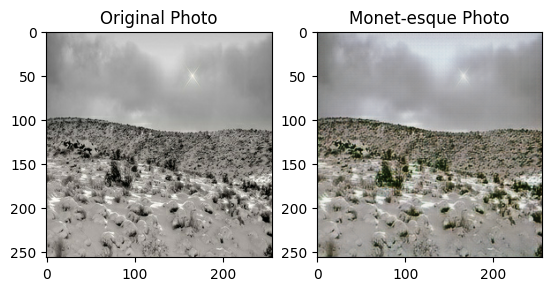

In [30]:
to_monet = generator_m(example_photo, training=False)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

## Build and Train a CycleGAN (Kaggle Tutorial)

### Build the Generator

The Generator is based on U-NET architecture.

#### Define Generator Functions

To build the Generator, let's define the `downsample` and `upsample` functions.

##### Downsample Method

Reduces the 2D dimensions, the width and height, of the image by the stride. The stride is the length of the step the filter takes. Since the stride is 2, the filter is applied to every other pixel, hence reducing the weight and height by 2.

In [70]:
OUTPUT_CHANNELS = 3

# downsample function
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

##### Upsample Method

Does the opposite of downsample and increases the dimensions of the of the image. `Conv2DTranspose` does basically the opposite of a `Conv2D` layer.

In [71]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

#### Define Generator Architecture

The generator first downsamples the input image and then upsample while establishing long skip connections. Skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one. Here we concatenate the output of the downsample layer to the upsample layer in a symmetrical fashion.

In [72]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

### Build the Discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [73]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [74]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

Since our generators are not trained yet, the generated Monet-esque photo does not show what is expected at this point.

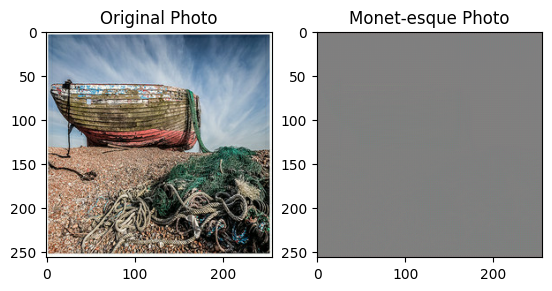

In [75]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

### Build the CycleGAN model

Create a subclass `tf.keras.Model` so that we can run `fit()` later to train our model. During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another.

The losses are defined in the next section.

In [76]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### Define Loss Functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

In [77]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [78]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

In [79]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [80]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

### Train the CycleGAN

Let's compile our model. Since we used `tf.keras.Model` to build our CycleGAN, we can just ude the `fit` function to train our model.

In [81]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [82]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [83]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
300/300 [==============================] - 175s 178ms/step - monet_gen_loss: 5.2489 - photo_gen_loss: 5.3867 - monet_disc_loss: 0.6204 - photo_disc_loss: 0.6106
Epoch 2/25
300/300 [==============================] - 54s 179ms/step - monet_gen_loss: 3.7654 - photo_gen_loss: 4.0236 - monet_disc_loss: 0.6586 - photo_disc_loss: 0.5467
Epoch 3/25
300/300 [==============================] - 54s 178ms/step - monet_gen_loss: 3.6976 - photo_gen_loss: 4.0567 - monet_disc_loss: 0.6655 - photo_disc_loss: 0.5571
Epoch 4/25
300/300 [==============================] - 53s 178ms/step - monet_gen_loss: 3.6244 - photo_gen_loss: 3.9662 - monet_disc_loss: 0.6448 - photo_disc_loss: 0.5761
Epoch 5/25
300/300 [==============================] - 53s 178ms/step - monet_gen_loss: 3.4669 - photo_gen_loss: 3.7522 - monet_disc_loss: 0.6380 - photo_disc_loss: 0.5869
Epoch 6/25
300/300 [==============================] - 53s 178ms/step - monet_gen_loss: 3.3210 - photo_gen_loss: 3.5421 - monet_disc_loss: 0.6288

## Results & Analysis

### Visualize the Monet-esque Photos by CycleGANs

Let's the display the Monet-esque Photos created by the CycleGAN from TensorFlow Tutorial.

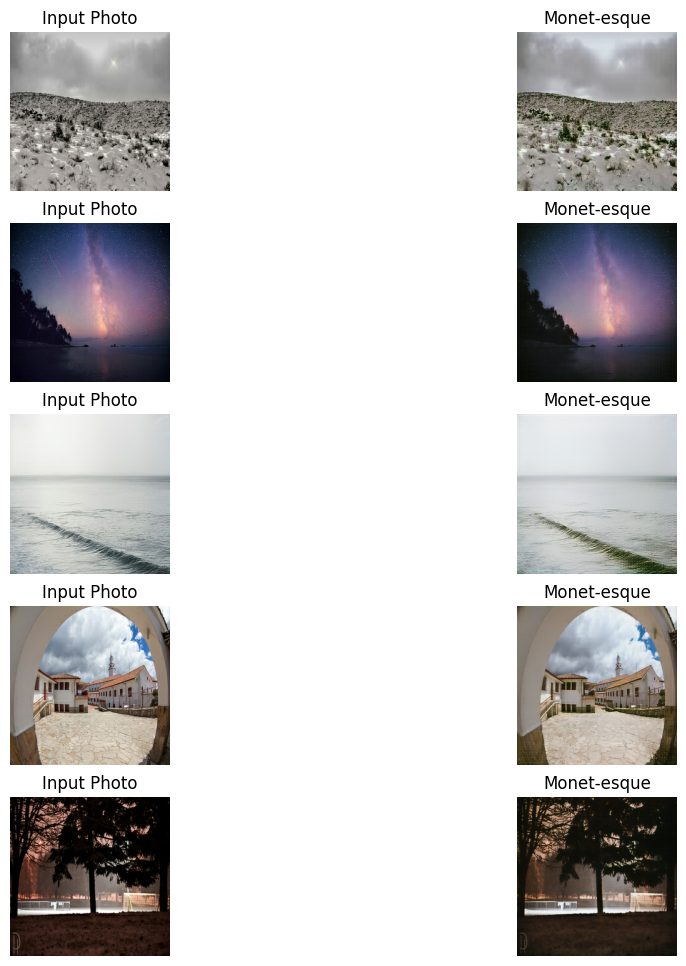

In [32]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = generator_m(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

Now, let's display the Monet-esque Photos created by the CycleGAN from Kaggle Tutorial.

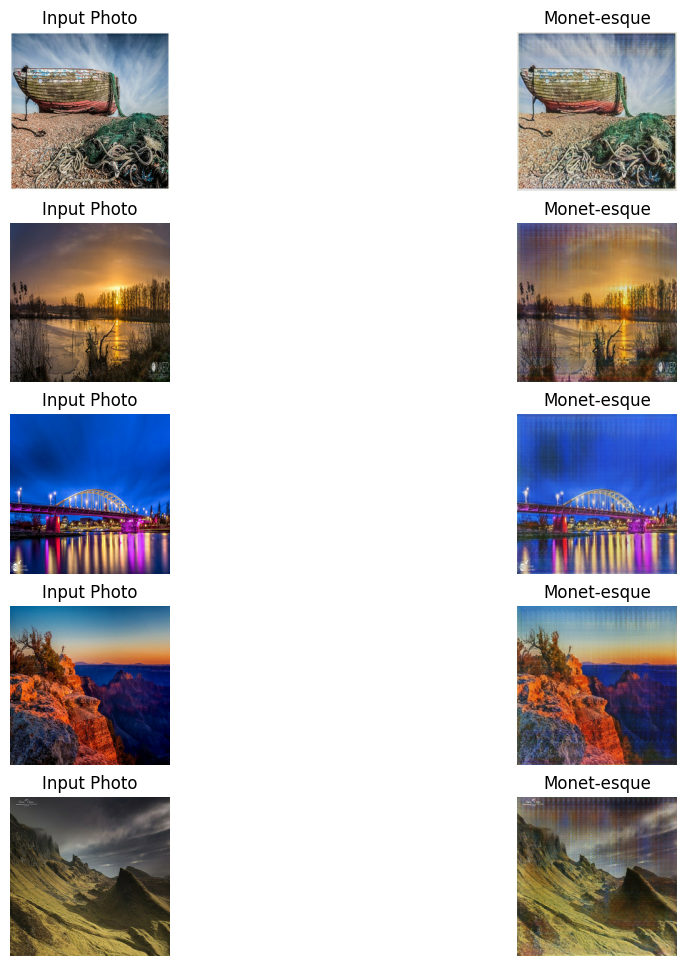

In [84]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

### Kaggle Scores and Leaderboard

Below the score achieved by the CycleGAN from TensorFlow tutorial:

![alt text](https://github.com/rojasael/DTSA/blob/main/5511/W5_Kaggle_Mini_Project/DTSA-5511_W5_Monet_Painting_Kaggle_Mini_Project%20-%20TF%20-%20Kaggle%20Score.png?raw=1)

and here the score achieved by the CycleGAN from Kaggle tutorial:

![alt text](https://github.com/rojasael/DTSA/blob/main/5511/W5_Kaggle_Mini_Project/DTSA-5511_W5_Monet_Painting_Kaggle_Mini_Project%20-%20KG%20-%20Kaggle%20Score.png?raw=1)

The Leaderboard position for the best model was:

![alt text](https://github.com/rojasael/DTSA/blob/main/5511/W5_Kaggle_Mini_Project/DTSA-5511_W5_Monet_Painting_Kaggle_Mini_Project%20-%20Kaggle%20Leaderboard.png?raw=1)

## Conclusion

For this project, we compared two CycleGAN models for generating images in the style of Monet's painting from orginal photos.

The competition requires the models to be evaluated on MiFID (Memorization-informed Fréchet Inception Distance) performance. The smaller MiFID is, the better the generated images are.

Our results indicated that the CycleGAN model built from Kaggle tutorial achieved a significantly higher MiFID score (71.6) compared to the model built from TensorFlow tutorial (81.7). The CycleGAN model from Kaggle tutorial achieved more noticable results in less epochs (25), while the CycleGAN model model from Tensorflow, we barely could notice the changes from the orginal photo to the monet-esque one after 30 epochs. This could be due to the differences in hyperparameter settings, and network architectures between the two models.

While CycleGANs can be complex for newcomers to the field, leveraging pre-built architectures like Pix2Pix for the Generator and Discriminator models simplifies the initial setup and aids in understanding the core concepts.

The CycleGAN design from Kaggle tutorial was quite difficult to graps at once, but after having implemented the design from TensorFlow tutorial made it easier to learn the core concepts behind it.

Future works could involve delving deeper into the specific differences between the two models' architectures and hyperparameter settings to better understand how they work, and how to optimize their performance and efficiency.

## Create Submission File

Create temporary folder to save the images, and then compress them into a zip file for submission.

In [85]:
import PIL
# create temporary folder to save images
! mkdir ../images

In [86]:
# predict the monet-esque photo, convert it into a .jpg file, and save it into the temp folder
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [88]:
import shutil
# compress image files into a zip file
shutil.make_archive("/kaggle/working/images", 'zip', "../images")

'/kaggle/working/images.zip'